# AKI MOFAcell

In [3]:
import os

In [4]:
data_dir = os.path.join('..', '..', 'data', 'kidney_injury')

In [5]:
# columns of interest
sample_key = "ident"
groupby = "cell_type"
condition_key = "Group"

### Setup Env

In [6]:
import numpy as np
import pandas as pd

import scanpy as sc

In [7]:
import mofax as mofa
import muon as mu
import mudata
import decoupler as dc

/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
import liana as li
import plotnine as p9
li.__version__

'0.1.9'

In [9]:
adata = sc.read_h5ad(os.path.join(data_dir, "aki_processed.h5ad"))

## Run MOFA

In [10]:
mdata = li.multi.adata_to_views(adata,
                                groupby=groupby,
                                sample_key=sample_key,
                                obs_keys=[condition_key],
                                min_prop=0.01, # min cell prop nnz values (filter features)
                                min_smpls=3, # min samples per view (filter features)
                                min_cells=25, # min cells per view (filter samples)
                                min_counts=50, # min counts per view (filter samples)
                                large_n=5,
                                mode='sum', # mode of aggregation
                                verbose=True,
                                layer='counts'
                                )


100%|██████████| 18/18 [00:52<00:00,  2.89s/it]


In [11]:
mdata

MuData object with n_obs × n_vars = 24 × 84846
  obs:	'Group'
  18 modalities
    CTAL:	24 x 7948
      layers:	'psbulk_props'
    PT:	24 x 14903
      layers:	'psbulk_props'
    EC:	24 x 7335
      layers:	'psbulk_props'
    DCT:	24 x 7324
      layers:	'psbulk_props'
    MTAL:	24 x 9739
      layers:	'psbulk_props'
    ICA:	24 x 2950
      layers:	'psbulk_props'
    Fib:	24 x 5570
      layers:	'psbulk_props'
    DCT-CNT:	18 x 2078
      layers:	'psbulk_props'
    MO:	23 x 1997
      layers:	'psbulk_props'
    PC:	24 x 8879
      layers:	'psbulk_props'
    ICB:	22 x 2932
      layers:	'psbulk_props'
    DTL-ATL:	23 x 5092
      layers:	'psbulk_props'
    Per:	5 x 81
      layers:	'psbulk_props'
    PEC:	8 x 368
      layers:	'psbulk_props'
    CNT:	24 x 5098
      layers:	'psbulk_props'
    Pod:	15 x 643
      layers:	'psbulk_props'
    Tcell:	9 x 56
      layers:	'psbulk_props'
    Uro:	20 x 1853
      layers:	'psbulk_props'

In [12]:
views = dict()
for view in mdata.mod.keys():
    # dc.plot_filter_by_expr(mdata.mod[view], min_count=10, min_total_count=200)
    keep_genes = dc.filter_by_expr(mdata.mod[view], group=None, min_count=5, min_total_count=20, min_prop=0.1, large_n=0)
    mdata.mod[view] = mdata.mod[view][:, keep_genes].copy()
    
    sc.pp.normalize_total(mdata.mod[view], target_sum=1e4)
    sc.pp.log1p(mdata.mod[view])
    sc.pp.highly_variable_genes(mdata.mod[view])
    
    views[view] = mdata.mod[view]

In [13]:
obs = mdata.obs
# rebuild with re-filtered features
mdata = mudata.MuData(views)
mdata.obs = obs

In [14]:
mdata.mod['MTAL'].var

,highly_variable,means,dispersions,dispersions_norm
MTAL:0610005C13Rik,True,0.136879,-2.123738,0.756426
MTAL:0610009B22Rik,True,0.146145,-2.229270,0.589569
MTAL:0610009O20Rik,False,0.184798,-3.332340,-1.154503
MTAL:0610010F05Rik,False,0.518977,-2.299983,-0.662384
MTAL:0610030E20Rik,False,0.218354,-2.827343,-0.356048
...,...,...,...,...
MTAL:Zzz3,True,0.473432,-1.429551,0.611886
MTAL:a,False,0.274419,-2.584788,0.027457
MTAL:mt-Cytb,True,0.112776,-2.185621,0.658584
MTAL:mt-Nd1,True,0.155871,-1.356579,1.969388


In [15]:
mu.tl.mofa(mdata,
           use_obs='union',
           convergence_mode='medium',
           n_factors=5,
           outfile='models/mofacell.h5ad',
           use_var='highly_variable'
           )


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        
Loaded view='CTAL' group='group1' with N=24 samples and D=2059 features...
Loaded view='PT' group='group1' with N=24 samples and D=4239 features...
Loaded view='EC' group='group1' with N=24 samples and D=2014 features...
Loaded view='DCT' group='group1' with N=24 samples and D=1855 features...
Loaded view='MTAL' group='group1' with N=24 samples and D=2606 features...
Loaded view

In [16]:
# obtain factor scores
factor_scores = li.multi.get_factor_scores(mdata, obsm_key='X_mofa')
factor_scores.head()

,ident,Factor1,Factor2,Factor3,Factor4,Factor5,Group
0,IRI12h1b1,0.866671,-0.095837,0.002483,-0.147651,-0.003700,12hours
1,IRI12h1b2,0.851058,-0.026238,0.031447,-0.131607,-0.013718,12hours
2,IRI12h2,0.816861,-0.065166,0.006253,-0.132024,-0.006926,12hours
3,IRI12h3,0.837689,-0.049877,0.019639,-0.135335,-0.010728,12hours
4,IRI14d1b1,-0.375176,-0.142054,-0.030455,0.027530,0.166822,14days


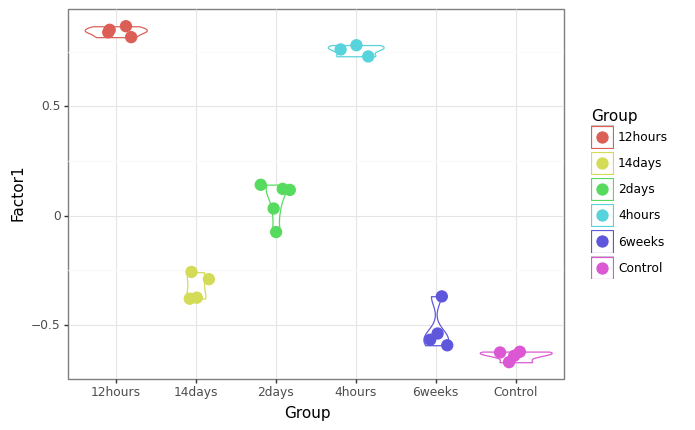

<ggplot: (8735457051745)>

In [17]:
(p9.ggplot(factor_scores) +
 p9.aes(x=condition_key, colour=condition_key, y='Factor1') +
 p9.geom_violin() +
 p9.geom_jitter(size=4, width=0.2) +
 p9.theme_bw()
 )

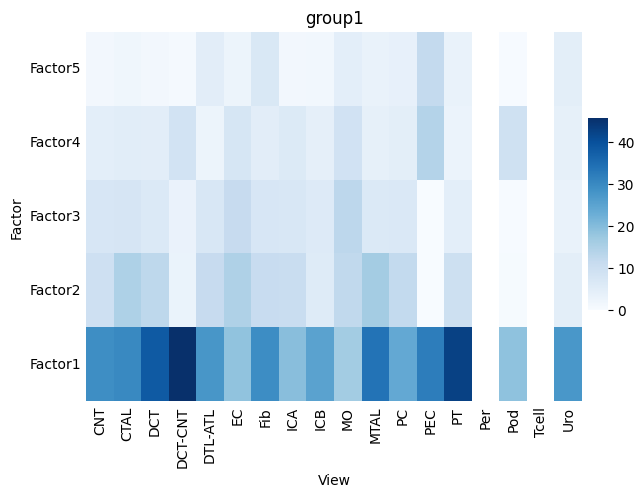

In [18]:
model = mofa.mofa_model("models/mofacell.h5ad")
model
mofa.plot_r2(model, x='View')

In [31]:
loadings =  li.multi.get_variable_loadings(mdata, view_separator=':') # get loadings for factor 1
loadings.head()

,view,variable,Factor1,Factor2,Factor3,Factor4,Factor5
33453,DCT,Klhl3,-1.866209,-1.132292,1.434064,-0.828184,0.376741
35543,DCT,Rtn4,1.705231,0.398374,-1.322183,-0.333908,-0.483218
19822,PT,Slc22a30,-1.684517,-0.927197,1.105985,0.047949,-0.123548
57279,DCT-CNT,Rtn4,1.613153,-0.269931,-1.819407,-2.523644,-0.107193
57292,DCT-CNT,Sat1,1.606420,0.055899,-0.726868,0.326151,0.060385


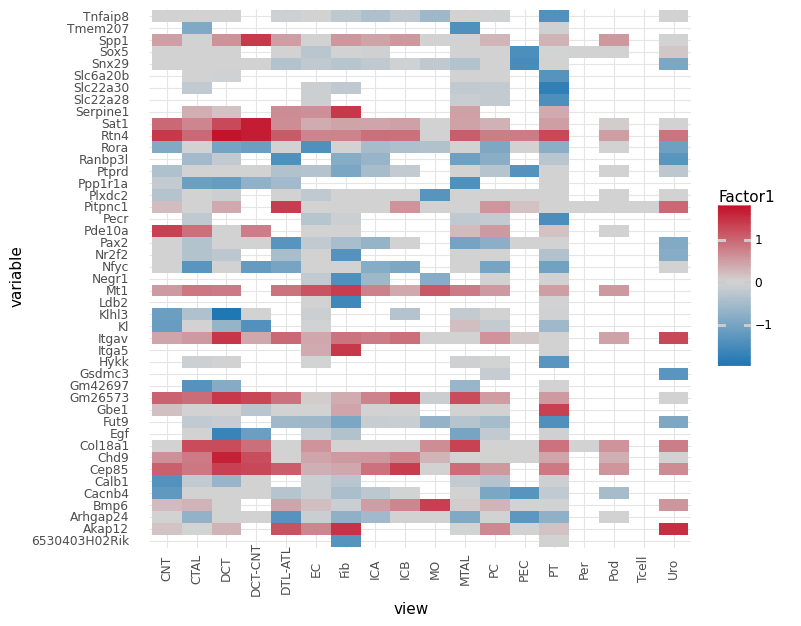

<ggplot: (8735447368930)>

In [32]:
# get 25 genes with highest loadings across all views
top_genes = loadings.sort_values(by='Factor1', key=lambda x: abs(x), ascending=False).head(50)['variable']
top_loadings = loadings[loadings['variable'].isin(top_genes)]
# ^ Note that the genes with the lowest loadings are equally interesting

# plot them
# dotplot of variable, view, loadings
(p9.ggplot(top_loadings) +
 p9.aes(x='view', y='variable', fill='Factor1') +
 p9.geom_tile() +
 p9.scale_fill_gradient2(low='#1f77b4', mid='lightgray', high='#c20019') +
 p9.theme_minimal() +
 p9.theme(axis_text_x=p9.element_text(angle=90, hjust=0.5, vjust=0.5), figure_size=(7, 7))
 )

Enrichment analysis

In [96]:
# load PROGENy pathways
progeny = dc.get_progeny(organism='Mus musculus', top=500)

# load dorothea TF-target interactions
net = dc.get_dorothea(organism='mouse')

In [97]:
# Factor1 loadings to list of matrices by view
loadings_per_view = {}
for view in mdata.mod.keys():
    mat = loadings[loadings['view'] == view]
    # pivot to matrix with values from Factor1, and views as rows

In [98]:
 # pivot to matrix with values from Factor1, and views as rows
loadings_per_view = loadings.pivot(index='view', columns='variable', values='Factor1')

In [99]:
# fill missing values with 0
loadings_per_view = loadings_per_view.fillna(0)

In [104]:
estimate, pvals = dc.run_ulm(loadings_per_view, progeny)

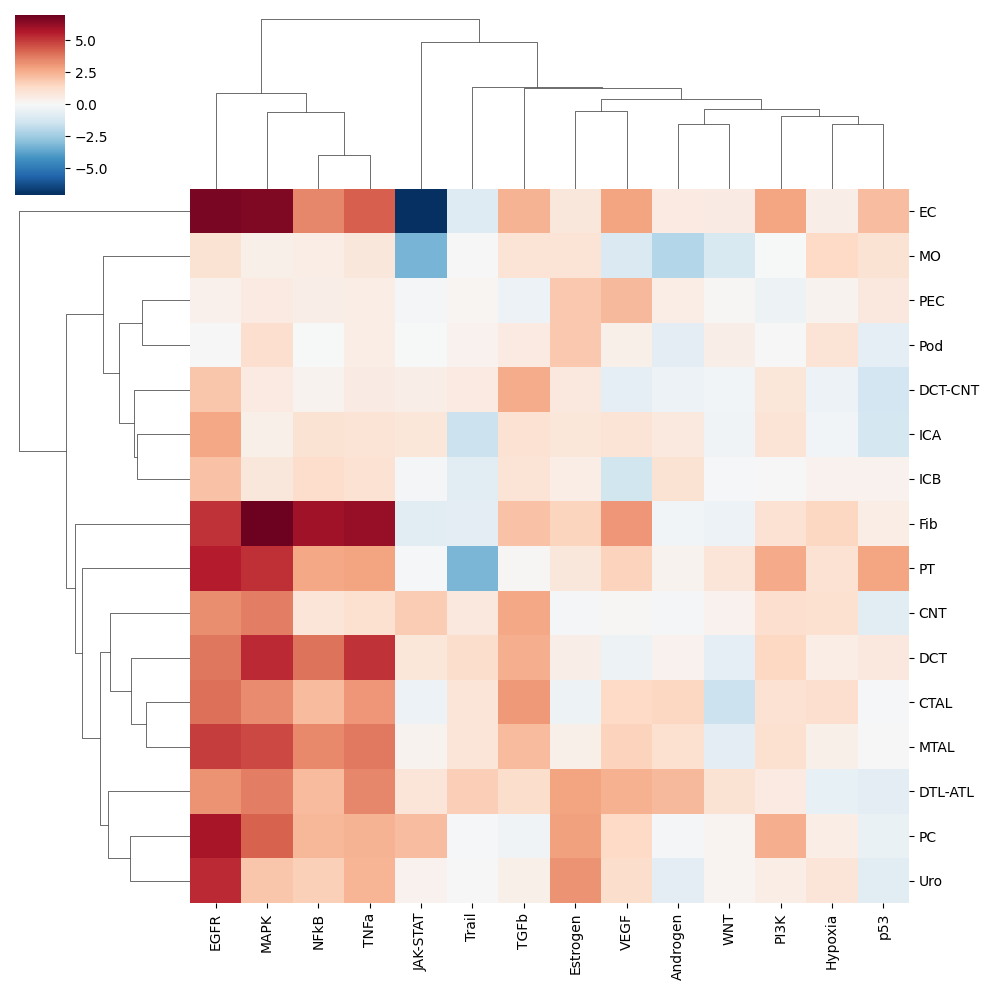

In [105]:
# seaborn heatmap
import seaborn as sns
sns.clustermap(estimate, cmap='RdBu_r',center=0, figsize=(10, 10))

TFs

In [70]:
estimate, pvals = dc.run_ulm(loadings_per_view, net)

In [71]:
estimate

,Ahr,Ar,Arid2,Arid3a,Arnt,Ascl1,Atf1,Atf2,Atf3,Atf4,...,Zeb2,Zfp644,Zfx,Zhx1,Zhx2,Zkscan1,Znf143,Znf24,Znf263,Znf639
CNT,3.030897,0.011967,2.185561,1.065460,2.010991,0.006926,-0.740478,1.133704,3.447561,-0.569045,...,1.385502,0.115147,0.156232,3.845869,2.601478,2.470458,1.848155,0.026832,-0.473189,1.559981
CTAL,1.387667,0.982125,4.407882,1.345465,0.873938,1.739984,-0.756691,1.347214,-0.641483,0.721450,...,0.891856,-0.043325,-0.297065,3.436427,0.851699,2.241290,1.407212,-1.274926,1.745184,0.389052
DCT,3.722287,2.015836,3.893760,1.305174,1.247696,-0.817872,1.631166,2.899339,1.221663,0.702071,...,1.581107,0.148054,1.958121,5.539014,2.703143,1.844885,0.462314,-1.948092,0.689132,1.858557
DCT-CNT,2.945412,0.712726,2.970348,0.336522,2.706994,-0.597503,1.191005,0.993866,3.724072,0.103193,...,2.395348,1.714038,1.376453,5.837731,-0.039902,3.334881,1.576397,-0.236713,2.223492,2.377612
DTL-ATL,6.023470,0.982434,0.245909,0.519884,-0.060283,-0.325343,1.246767,1.067628,1.282265,-0.194044,...,-1.198094,-0.327069,0.765528,1.886347,0.944748,1.456566,-0.896885,0.422008,0.338778,0.026024
EC,3.860875,2.594484,1.566234,1.238001,-0.931116,1.778145,1.001152,2.444785,2.350325,0.145976,...,0.078226,-0.722909,-0.232679,0.522166,1.102316,1.106048,2.304825,-1.341057,1.921914,-0.037199
Fib,3.137777,1.555153,0.529373,1.901113,-1.653625,-0.769023,1.480108,0.311988,2.334767,0.620220,...,-0.050736,-0.120733,0.647550,1.087070,0.919473,1.322307,0.842320,0.106361,-0.788350,0.444065
ICA,1.675226,1.221747,1.767471,1.134337,0.762872,-0.519022,-0.488740,-0.061695,1.473939,-1.910105,...,1.039554,0.028090,0.388484,2.106396,0.030773,2.257378,-0.178636,0.043537,0.739184,0.764768
ICB,1.533755,0.232276,1.686412,1.329365,0.500329,-1.775795,0.429827,2.089956,0.376974,-1.151866,...,0.485330,0.023591,0.247168,2.571973,0.025844,2.534379,0.489966,0.036563,-1.530904,-0.111862
MO,2.958606,0.944689,-1.404395,0.243372,-0.722457,-1.218811,-1.688351,-0.053515,0.847134,0.560308,...,-0.394875,0.150854,-1.476299,-1.415387,2.469606,0.360940,-0.982148,-0.342254,0.630799,-1.959316


In [72]:
# get top 10 TFs
top_tfs = estimate.abs().sum(axis=0).sort_values(ascending=False).head(10).index

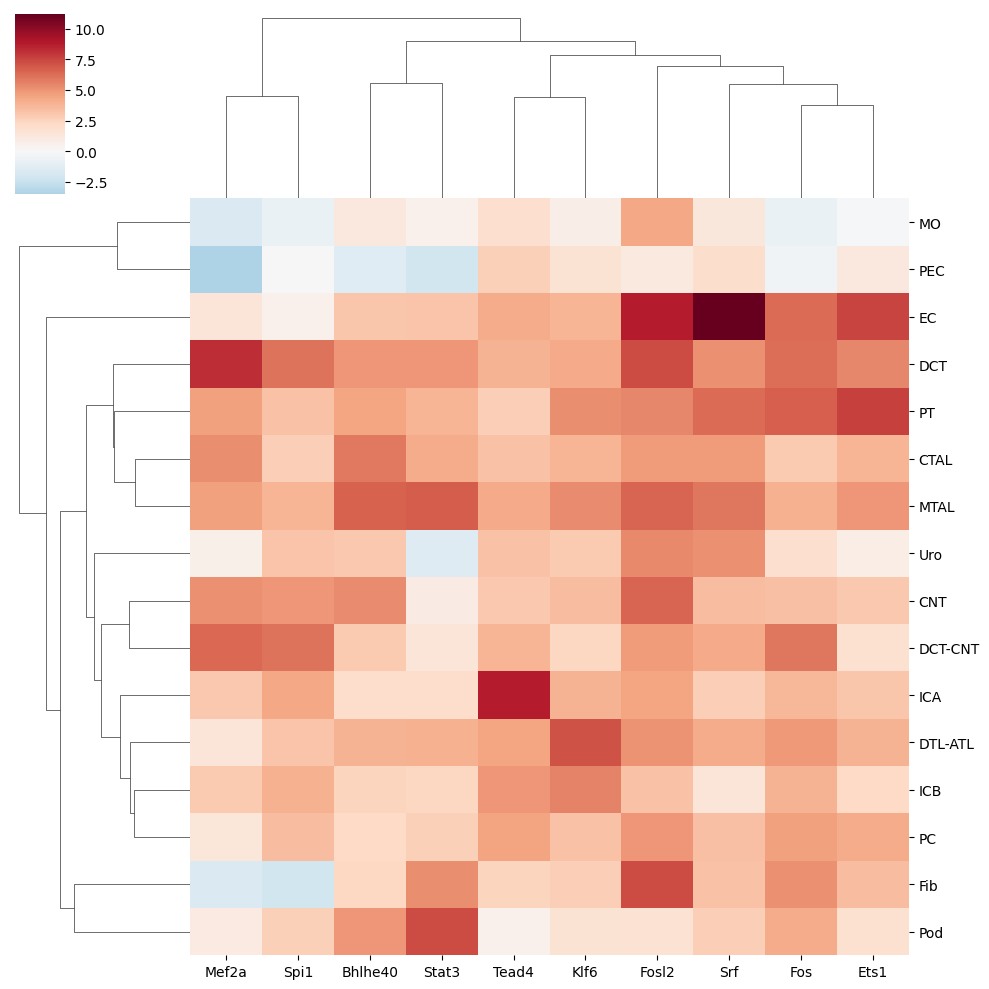

In [77]:
# heatmap of top TFs
sns.clustermap(estimate[top_tfs], cmap='RdBu_r',center=0, figsize=(10, 10))

In [89]:
important_views =  model.get_r2().sort_values("R2", ascending=False).head(10)['View']

In [91]:
# Top 3 TFs per important view
tfs = []
for view in important_views:
    tfs.extend(estimate.loc[view].abs().sort_values(ascending=False).head(3).index)
    
    

In [94]:
tfs = np.unique(tfs)

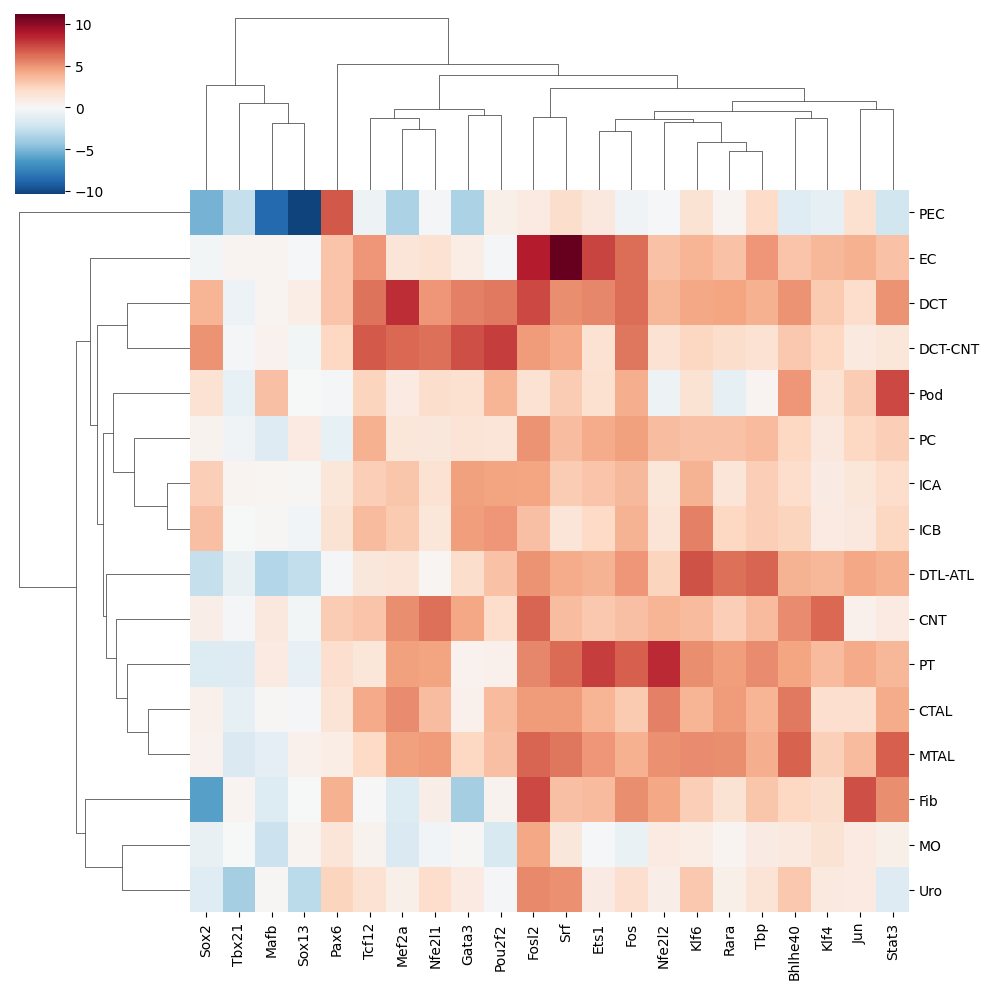

In [95]:
sns.clustermap(estimate[tfs], cmap='RdBu_r',center=0, figsize=(10, 10))